# KneeMRI dataset Extraction and Pre-Processing

In [ ]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import random

data_dir = 'D:/project/raw data'
metadata_file = 'D:/project/metadata.csv'
data = 'D:/project/data'
roi_output_dir = 'D:/project/with_roi1'
no_roi_output_dir = 'D:/project/without_roi'

metadata = pd.read_csv(metadata_file)

def load_pck_file(file_path):
    with open(file_path, 'rb') as file:
        volume = pickle.load(file)
    return volume

def extract_roi(volume, roi_x, roi_y, roi_z, height, width, depth, percentage=0.05):
    z_dim, y_dim, x_dim = volume.shape

    x_adjustment = int(width * percentage)
    y_adjustment = int(height * percentage)
    z_adjustment = int(depth * percentage)

    x1 = roi_x
    y1 = roi_y
    z1 = roi_z
    x2 = roi_x + width
    y2 = roi_y + height
    z2 = roi_z + depth

    adjustment_x = int((x2 - x1) * (random.uniform(-1, 1)) * percentage)
    adjustment_y = int((y2 - y1) * (random.uniform(-1, 1)) * percentage)
    adjustment_z = int((z2 - z1) * (random.uniform(-1, 1)) * percentage)

    x_start = max(0, x1 + adjustment_x)
    y_start = max(0, y1 + adjustment_y)
    z_start = max(0, z1 + adjustment_z)

    x_end = min(x_dim, x2 + adjustment_x)
    y_end = min(y_dim, y2 + adjustment_y)
    z_end = min(z_dim, z2 + adjustment_z)

    print(f"Volume dimensions: {volume.shape}")
    print(f"Original ROI: x:{roi_x}, y:{roi_y}, z:{roi_z}, height:{height}, width:{width}, depth:{depth}")
    print(f"Adjusted ROI: x_start:{x_start}, y_start:{y_start}, z_start:{z_start}, x_end:{x_end}, y_end:{y_end}, z_end:{z_end}")

    if x_start >= x_end or y_start >= y_end or z_start >= z_end:
        print("ROI is out of bounds.")
        return None

    roi = volume[z_start:z_end, y_start:y_end, x_start:x_end]
    return roi

def visualize_and_save_slices(roi, exam_id, series_no, knee_lr, diagnosis_label, output_dir, with_roi=True):
    if roi is not None:
        save_dir = os.path.join(output_dir, str(diagnosis_label))
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        for i in range(roi.shape[0]):
            slice_img = Image.fromarray((roi[i, :, :] * 255).astype(np.uint8))
            slice_img = slice_img.convert("L")
            save_path = os.path.join(save_dir, f"{exam_id}_series{series_no}_slice{i}_{knee_lr}_{'roi' if with_roi else 'no_roi'}.jpg")
            slice_img.save(save_path)

for filename in os.listdir(data_dir):
  if filename.endswith('.pck'):
      file_path = os.path.join(data_dir, filename)
      print(f"Processing file: {file_path}")

      try:
          volume = load_pck_file(file_path)

          file_metadata = metadata[metadata['volumeFilename'] == filename].iloc[0]

          exam_id = str(file_metadata['examId'])
          series_no = str(file_metadata['seriesNo'])
          diagnosis = file_metadata['aclDiagnosis']
          knee_lr = 'L' if file_metadata['kneeLR'] == 1 else 'R'
          roi_x = int(file_metadata['roiX'])
          roi_y = int(file_metadata['roiY'])
          roi_z = int(file_metadata['roiZ'])
          roi_height = int(file_metadata['roiHeight'])
          roi_width = int(file_metadata['roiWidth'])
          roi_depth = int(file_metadata['roiDepth'])

          visualize_and_save_slices(volume, exam_id, series_no, knee_lr, diagnosis, no_roi_output_dir, with_roi=False)

          roi = extract_roi(volume, roi_x, roi_y, roi_z, roi_height, roi_width, roi_depth, percentage=0.05)
          if roi is not None:
              print(f"Extracted ROI shape: {roi.shape}")
              visualize_and_save_slices(roi, exam_id, series_no, knee_lr, diagnosis, roi_output_dir, with_roi=True)

      except Exception as e:
          print(f"Error processing file {file_path}: {e}")

In [ ]:
import os
import cv2
import numpy as np
from skimage import exposure 
import matplotlib.pyplot as plt

input_dir = 'D:/project/with_roi1'
output_dir = 'D:/project/with_roi_histactual3'

os.makedirs(output_dir, exist_ok=True)
for class_label in ['0', '1', '2']:
    os.makedirs(os.path.join(output_dir, class_label), exist_ok=True)

for class_label in ['0', '1', '2']:
    class_input_dir = os.path.join(input_dir, class_label)
    class_output_dir = os.path.join(output_dir, class_label)

    for image_name in os.listdir(class_input_dir):
        if image_name.endswith('.jpg'):  
            
            image_path = os.path.join(class_input_dir, image_name)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            
            if image is None:
                print(f"Error loading image {image_path}. Skipping...")
                continue

            equalized_image = exposure.equalize_hist(image)
            
            equalized_image_uint8 = (equalized_image * 255).astype(np.uint8)

            output_image_path = os.path.join(class_output_dir, image_name)
            cv2.imwrite(output_image_path, equalized_image_uint8)

            if np.random.rand() < 0.1:  
                plt.figure(figsize=(10, 4))
                plt.subplot(1, 2, 1)
                plt.hist(image.ravel(), bins=256, color='gray', alpha=0.75)
                plt.title('Original Histogram')
                plt.subplot(1, 2, 2)
                plt.hist(equalized_image_uint8.ravel(), bins=256, color='gray', alpha=0.75)
                plt.title('Equalized Histogram')
                plt.show()

print("Histogram equalization complete for all images.")


# MRNet Dataset Extraction

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
from tqdm.auto import tqdm
tqdm.pandas()

import monai.transforms as MT
from monai.visualize.utils import matshow3d

from timm import list_models, create_model

from scipy import ndimage as nd

import evaluate
from accelerate import Accelerator, notebook_launcher
from safetensors.torch import load_model

%env CUDA_LAUNCH_BLOCKING='1'
torch.autograd.set_detect_anomaly(True)

def extract_3d_roi(image):

    # Calculate the center of the image
    center_depth = image.shape[0] // 2
    center_height = image.shape[1] // 2
    center_width = image.shape[2] // 2

    # Calculate the cropping bounds for each dimension
    depth_start = center_depth - 3
    depth_end = center_depth + 3

    # Extract the 3D ROI from the image
    roi = image[depth_start:depth_end, :, :]
    
    return roi

def convert_npy_to_jpeg(npy_file_path, png_file_path):
    # Load the numpy array
    np_array = np.load(npy_file_path)
    
    roi = extract_3d_roi(np_array)

    for i in range(roi.shape[0]):  # Iterate over slices
        single_slice = roi[i, :, :]
        single_slice = single_slice - np.min(single_slice)
        single_slice = single_slice / np.ptp(single_slice)
        single_slice = np.uint8(single_slice * 255)

        pil_image = Image.fromarray(single_slice, mode='L')
        pil_image.save(f"{png_file_path}_slice_{i}.png", 'PNG')

    print(f"Image saved as PNG: {png_file_path}")
    
def create_df(mode='train'):
    
    sagittal = Path(f'D:/project/mrnet-v1/{mode}/sagittal')
    axial = Path(f'D:/project/mrnet-v1/{mode}/axial')
    coronal = Path(f'D:/project/mrnet-v1/{mode}/coronal')
    axis = [sagittal, axial, coronal]
    labels = ['acl','meniscus','abnormal']
    base_path = Path('D:/project/mrnet-v1')
    paths = [base_path/f"{mode}-{l}.csv" for l in labels]
    
    l1 = pd.read_csv(
        paths[0],
        header=None,
        names=['case', labels[0]], 
        dtype={'case': str, labels[0]: np.int64}
    )
    l2 = pd.read_csv(
        paths[1],
        header=None,
        names=['case', labels[1]], 
        dtype={'case': str, labels[1]: np.int64}
    )
    l3 = pd.read_csv(
        paths[2],
        header=None,
        names=['case', labels[2]], 
        dtype={'case': str, labels[2]: np.int64}
    )
    final_df = pd.DataFrame({
        'case': l1['case'],
        labels[0]: l1[labels[0]],
        labels[1]: l2[labels[1]],
        labels[2]: l3[labels[2]],
    })
    
    for ax in axis:
        final_df[ax.stem] = final_df['case'].progress_map(lambda p: ax / f"{p}.npy")  
    return final_df

train_df = create_df(mode='train')
valid_df = create_df(mode='valid')

for label in ['acl','meniscus','abnormal']:
    print(label)
    print('train',train_df[label].value_counts().to_dict())
    print('valid',valid_df[label].value_counts().to_dict())
    
base_save_dir = Path("D:/project/mrnetdata")
base_save_dir.mkdir(parents=True, exist_ok=True)

# Function to create and save images in modality-specific folders
def save_images(df, mode, class_label):
    for modality in ['sagittal', 'axial', 'coronal']:
        # Create subdirectories for each modality
        modality_dir = base_save_dir / f"{mode}" / f"{class_label}" / modality
        modality_dir.mkdir(parents=True, exist_ok=True)
        
        # Save images for the current modality
        for _, row in df.iterrows():
            case_path = row[modality]
            jpeg_file_path = modality_dir / f"{row['case']}"
            # Convert .npy to .jpeg and save
            convert_npy_to_jpeg(case_path, jpeg_file_path)

# Filter for ACL class 0 and 1
class_0_dft = train_df[train_df['acl'] == 0]
class_1_dft = train_df[train_df['acl'] == 1]

# Save images for both classes
save_images(class_0_dft, 'train', 0)
save_images(class_1_dft, 'train', 1)

class_0_dfv = valid_df[valid_df['acl'] == 0]
class_1_dfv = valid_df[valid_df['acl'] == 1]

# Save images for both classes
save_images(class_0_dfv, 'valid', 0)
save_images(class_1_dfv, 'valid', 1)

print(f"Saved ACL images for class 0 and 1 in {base_save_dir}")


# Visualisation

Number of images from each class:
aclDiagnosis
Healthy               547
Partially Ruptured    144
Fully Ruptured         45
Name: count, dtype: int64


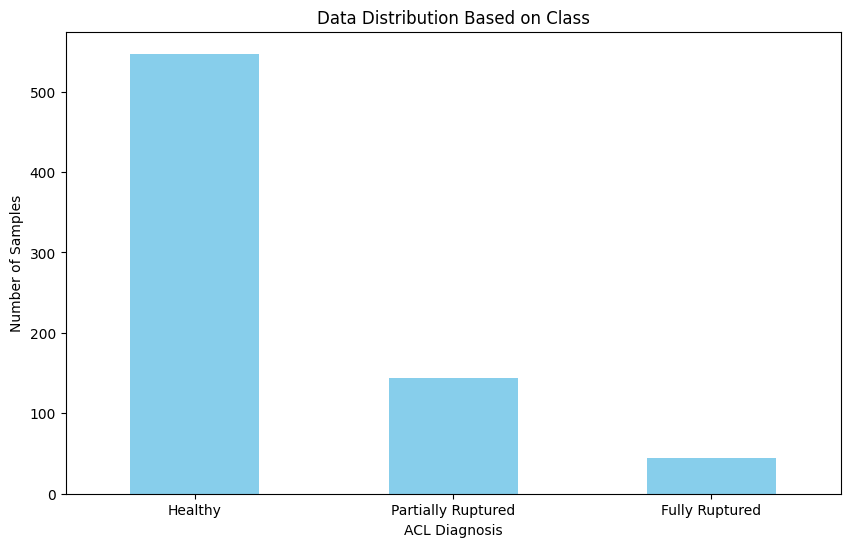

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the path to your metadata CSV file
metadata_file = 'D:/project1/metadata.csv'

# Load the metadata from the CSV file
metadata = pd.read_csv(metadata_file)

# Define a mapping from class labels to descriptions
class_labels = {
    0: 'Healthy',
    1: 'Partially Ruptured',
    2: 'Fully Ruptured'
}

# Replace numeric class labels with descriptions
metadata['aclDiagnosis'] = metadata['aclDiagnosis'].map(class_labels)

# Print the number of images from each class
print("Number of images from each class:")
class_counts = metadata['aclDiagnosis'].value_counts()
print(class_counts)

# Plot the data distribution based on the class (e.g., aclDiagnosis)
plt.figure(figsize=(10, 6))

# Plot the class distribution
class_counts.plot(kind='bar', color='skyblue')
plt.title('Data Distribution Based on Class')
plt.xlabel('ACL Diagnosis')
plt.ylabel('Number of Samples')
plt.xticks(rotation=0)
plt.show()



Number of images in folders:
Healthy: 1845
Partially Ruptured: 485
Fully Ruptured: 156


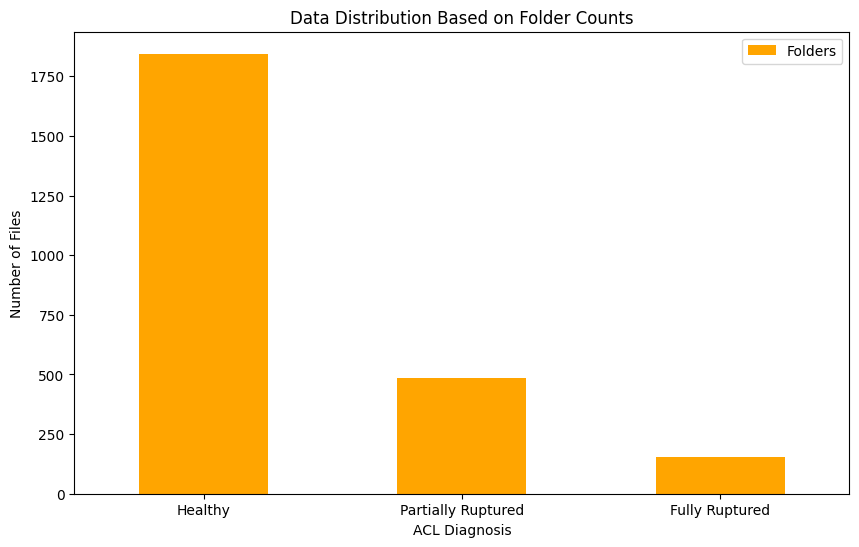

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Define the path to your image folders
image_folder_path = 'D:/project1/with_roifhist'

# Define a mapping from class labels to descriptions
class_labels = {
    '0': 'Healthy',
    '1': 'Partially Ruptured',
    '2': 'Fully Ruptured'
}

folder_counts = {}
for label, description in class_labels.items():
    folder_path = os.path.join(image_folder_path, label)
    if os.path.exists(folder_path):
        folder_counts[description] = len(os.listdir(folder_path))
    else:
        folder_counts[description] = 0

# Print the number of images in folders
print("\nNumber of images in folders:")
for description, count in folder_counts.items():
    print(f"{description}: {count}")

# Plot the data distribution based on folder counts
plt.figure(figsize=(10, 6))
folder_count_series = pd.Series(folder_counts)
folder_count_series.plot(kind='bar', color='orange', label='Folders')
plt.title('Data Distribution Based on KneeMRI')
plt.xlabel('ACL Diagnosis')
plt.ylabel('Number of Files')
plt.xticks(rotation=0)
plt.legend()
plt.show()



Number of images in folders:
Healthy: 1845
Partially Ruptured: 1753
Fully Ruptured: 1659


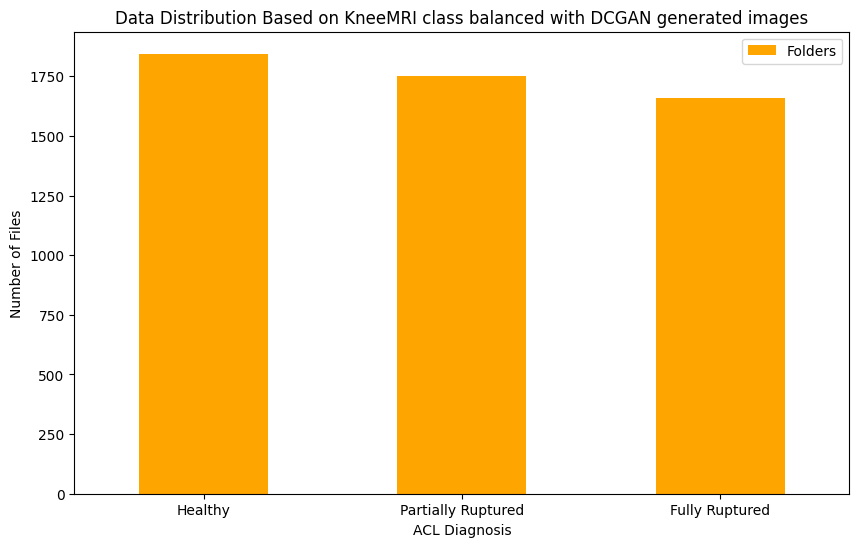

In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Define the path to your image folders
image_folder_path = 'D:/project1/with_roi'

# Define a mapping from class labels to descriptions
class_labels = {
    '0': 'Healthy',
    '1': 'Partially Ruptured',
    '2': 'Fully Ruptured'
}

folder_counts = {}
for label, description in class_labels.items():
    folder_path = os.path.join(image_folder_path, label)
    if os.path.exists(folder_path):
        folder_counts[description] = len(os.listdir(folder_path))
    else:
        folder_counts[description] = 0

# Print the number of images in folders
print("\nNumber of images in folders:")
for description, count in folder_counts.items():
    print(f"{description}: {count}")

# Plot the data distribution based on folder counts
plt.figure(figsize=(10, 6))
folder_count_series = pd.Series(folder_counts)
folder_count_series.plot(kind='bar', color='orange', label='Folders')
plt.title('Data Distribution Based on KneeMRI class balanced with DCGAN generated images')
plt.xlabel('ACL Diagnosis')
plt.ylabel('Number of Files')
plt.xticks(rotation=0)
plt.legend()
plt.show()



Number of images in folders:
Healthy: 547
Partially Ruptured: 144
Fully Ruptured: 45


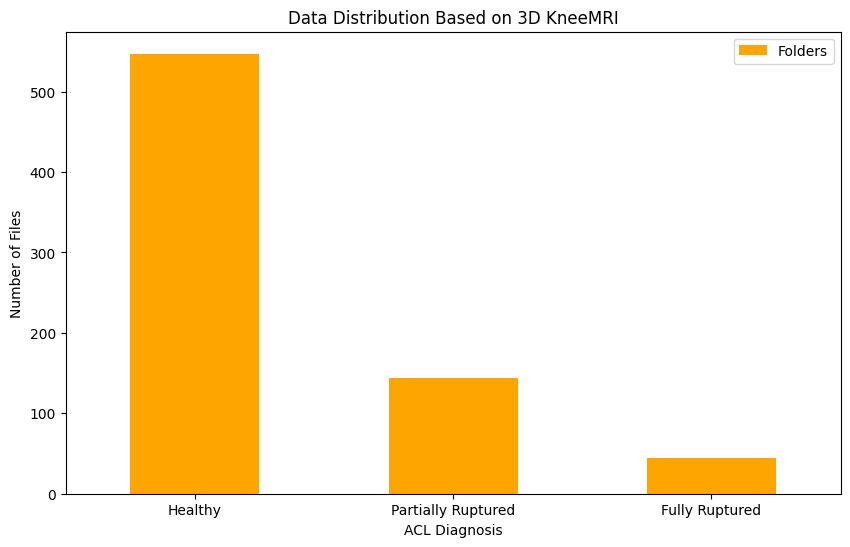

In [10]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Define the path to your image folders
image_folder_path = 'D:/project1/KneeMRI3D'

# Define a mapping from class labels to descriptions
class_labels = {
    '0': 'Healthy',
    '1': 'Partially Ruptured',
    '2': 'Fully Ruptured'
}

folder_counts = {}
for label, description in class_labels.items():
    folder_path = os.path.join(image_folder_path, label)
    if os.path.exists(folder_path):
        folder_counts[description] = len(os.listdir(folder_path))
    else:
        folder_counts[description] = 0

# Print the number of images in folders
print("\nNumber of images in folders:")
for description, count in folder_counts.items():
    print(f"{description}: {count}")

# Plot the data distribution based on folder counts
plt.figure(figsize=(10, 6))
folder_count_series = pd.Series(folder_counts)
folder_count_series.plot(kind='bar', color='orange', label='Folders')
plt.title('Data Distribution Based on 3D KneeMRI')
plt.xlabel('ACL Diagnosis')
plt.ylabel('Number of Files')
plt.xticks(rotation=0)
plt.legend()
plt.show()



Number of images in folders:
Healthy: 3688
ACL train: 3579


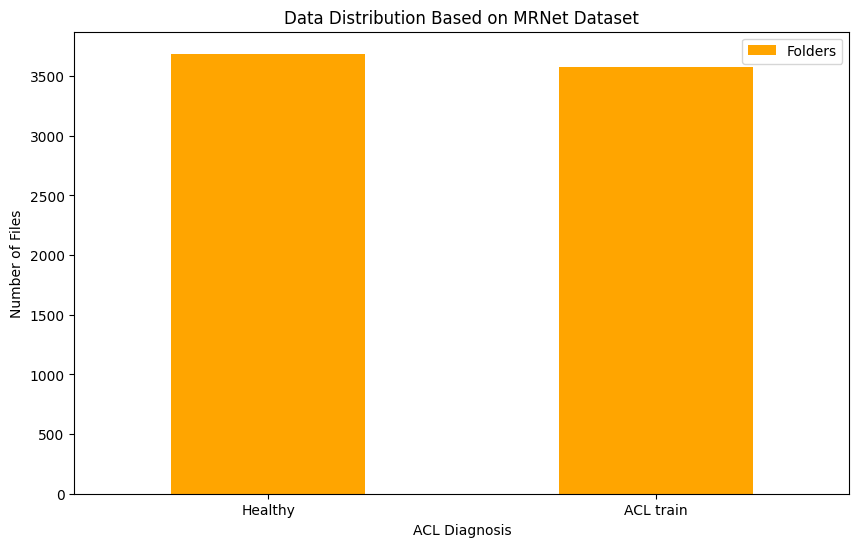

In [9]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Define the path to your image folders
image_folder_path = 'D:/project1/mrnetdata/train'

# Define a mapping from class labels to descriptions
class_labels = {
    '0': 'Healthy',
    '1': 'ACL train'
}

view = "axial"
folder_counts = {}
for label, description in class_labels.items():
    folder_path = os.path.join(image_folder_path, label)
    folder_path = os.path.join(folder_path, view)
    if os.path.exists(folder_path):
        folder_counts[description] = len(os.listdir(folder_path))
    else:
        folder_counts[description] = 0

# Print the number of images in folders
print("\nNumber of images in folders:")
for description, count in folder_counts.items():
    print(f"{description}: {count}")

# Plot the data distribution based on folder counts
plt.figure(figsize=(10, 6))
folder_count_series = pd.Series(folder_counts)
folder_count_series.plot(kind='bar', color='orange', label='Folders')
plt.title('Data Distribution Based on MRNet Dataset')
plt.xlabel('ACL Diagnosis')
plt.ylabel('Number of Files')
plt.xticks(rotation=0)
plt.legend()
plt.show()
